In [3]:
import json
import os
import numpy as np
import pandas as pd

Descriptive stats

In [4]:
from collections import defaultdict

folder_path = 'data/'
num_files = 1000  

file_pattern = [os.path.join(folder_path, f'mpd.slice.{i * 1000}-{(i + 1) * 1000 - 1}.json') for i in range(num_files)]

def summarize_file(file_path):
    summary = defaultdict(lambda: {'type': None, 'examples': []})
    
    with open(file_path, 'r') as file:
        data = json.load(file)
        
        # Analyze "info" section
        for key, value in data.get("info", {}).items():
            summary[f"info.{key}"]['type'] = type(value).__name__
            if len(summary[f"info.{key}"]['examples']) < 5:
                summary[f"info.{key}"]['examples'].append(value)
        
        # Analyze "playlists" section
        for playlist in data.get("playlists", []):
            for key, value in playlist.items():
                if key != "tracks":
                    summary[f"playlists.{key}"]['type'] = type(value).__name__
                    if len(summary[f"playlists.{key}"]['examples']) < 5:
                        summary[f"playlists.{key}"]['examples'].append(value)
            
            # Analyze "tracks" section
            for track in playlist.get("tracks", []):
                for key, value in track.items():
                    summary[f"tracks.{key}"]['type'] = type(value).__name__
                    if len(summary[f"tracks.{key}"]['examples']) < 5:
                        summary[f"tracks.{key}"]['examples'].append(value)
    
    return summary

sample_file = file_pattern[0]  
summary_data = summarize_file(sample_file)

summary_df = pd.DataFrame.from_dict(summary_data, orient='index')
summary_df.reset_index(inplace=True)
summary_df.columns = ['Variable', 'Type', 'Examples']

print(summary_df)

summary_df.to_csv('variable_summary.csv', index=False)


                   Variable Type  \
0         info.generated_on  str   
1                info.slice  str   
2              info.version  str   
3            playlists.name  str   
4   playlists.collaborative  str   
5             playlists.pid  int   
6     playlists.modified_at  int   
7      playlists.num_tracks  int   
8      playlists.num_albums  int   
9   playlists.num_followers  int   
10      playlists.num_edits  int   
11    playlists.duration_ms  int   
12    playlists.num_artists  int   
13               tracks.pos  int   
14       tracks.artist_name  str   
15         tracks.track_uri  str   
16        tracks.artist_uri  str   
17        tracks.track_name  str   
18         tracks.album_uri  str   
19       tracks.duration_ms  int   
20        tracks.album_name  str   
21    playlists.description  str   

                                             Examples  
0                        [2017-12-03 08:41:42.057563]  
1                                             [0-999]  
2  

Number of playlists: 1000000
Number of tracks: 66346428
Number of unique tracks: 2262292
Number of unique albums: 734684
Number of unique titles: 1483760


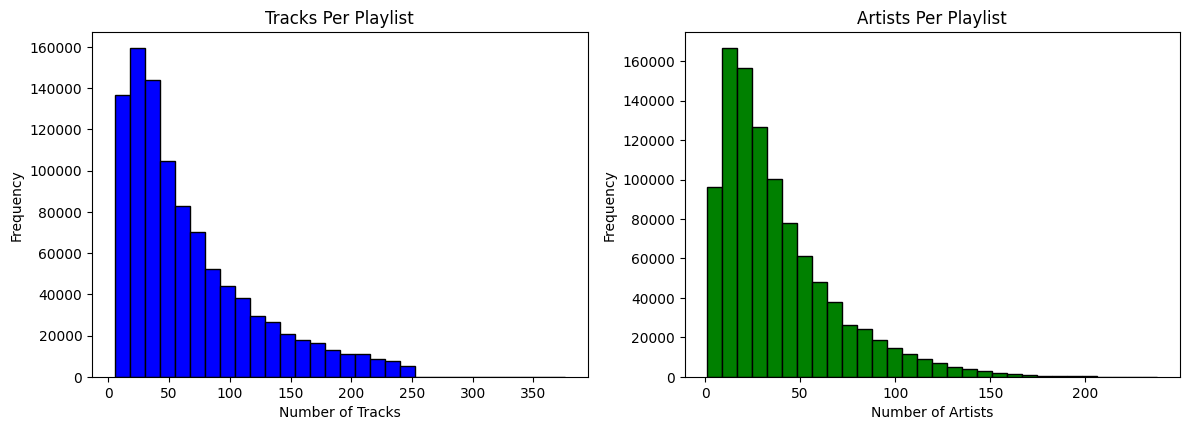

In [ ]:
import dask.bag as db
import matplotlib.pyplot as plt

folder_path = 'data/'
num_files = 1000  

file_pattern = [os.path.join(folder_path, f'mpd.slice.{i * 1000}-{(i + 1) * 1000 - 1}.json') for i in range(num_files)]

def process_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        playlist_count = 0
        track_count = 0
        unique_tracks = set()
        unique_albums = set()
        unique_titles = set()
        num_tracks_per_playlist = []
        num_artists_per_playlist = []

        for playlist in data['playlists']:
            playlist_count += 1
            num_tracks = playlist['num_tracks']
            track_count += num_tracks
            num_tracks_per_playlist.append(num_tracks)
            
            artists = {track['artist_name'] for track in playlist['tracks']}
            num_artists_per_playlist.append(len(artists))

            for track in playlist['tracks']:
                unique_tracks.add(track['track_uri'])
                unique_albums.add(track['album_uri'])
                unique_titles.add(track['track_name'])

        return playlist_count, track_count, unique_tracks, unique_albums, unique_titles, num_tracks_per_playlist, num_artists_per_playlist

results = db.from_sequence(file_pattern).map(process_file).compute()

total_playlists = 0
total_tracks = 0
all_unique_tracks = set()
all_unique_albums = set()
all_unique_titles = set()
all_tracks_per_playlist = []
all_artists_per_playlist = []

for playlists, tracks, unique_tracks, unique_albums, unique_titles, tracks_per_playlist, artists_per_playlist in results:
    total_playlists += playlists
    total_tracks += tracks
    all_unique_tracks.update(unique_tracks)
    all_unique_albums.update(unique_albums)
    all_unique_titles.update(unique_titles)
    all_tracks_per_playlist.extend(tracks_per_playlist)
    all_artists_per_playlist.extend(artists_per_playlist)

num_playlists = total_playlists
num_tracks = total_tracks
num_unique_tracks = len(all_unique_tracks)
num_unique_albums = len(all_unique_albums)
num_unique_titles = len(all_unique_titles)

print(f"Number of playlists: {num_playlists}")
print(f"Number of tracks: {num_tracks}")
print(f"Number of unique tracks: {num_unique_tracks}")
print(f"Number of unique albums: {num_unique_albums}")
print(f"Number of unique titles: {num_unique_titles}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(all_tracks_per_playlist, bins=30, edgecolor='black', color='blue')
plt.title('Tracks Per Playlist')
plt.xlabel('Number of Tracks')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(all_artists_per_playlist, bins=30, edgecolor='black', color='green')
plt.title('Artists Per Playlist')
plt.xlabel('Number of Artists')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Number of playlists: 1000000
Number of tracks: 66346428
Number of unique tracks: 2262292
Number of unique albums: 734684
Number of unique titles: 1483760


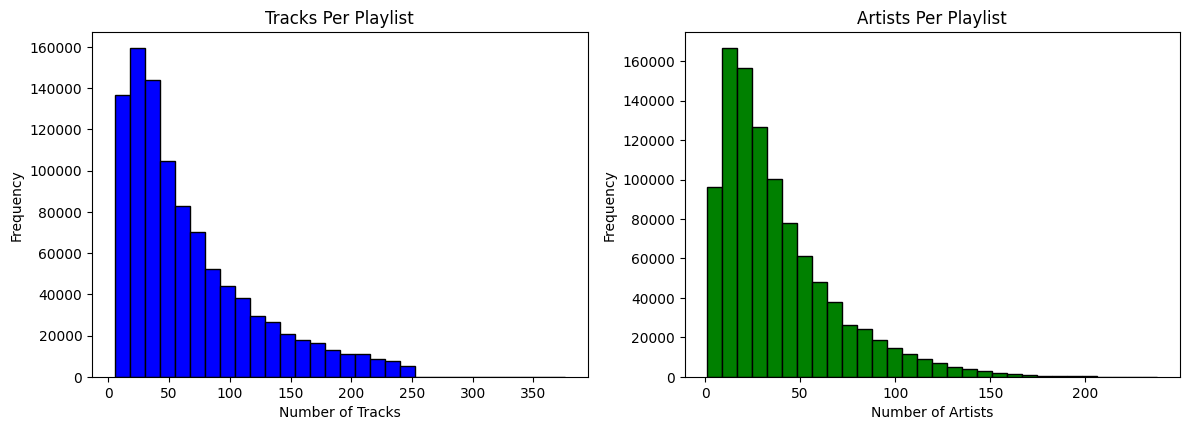

In [ ]:
import dask.bag as db
import matplotlib.pyplot as plt

folder_path = 'data/'
num_files = 1000 

file_pattern = [os.path.join(folder_path, f'mpd.slice.{i * 1000}-{(i + 1) * 1000 - 1}.json') for i in range(num_files)]

def process_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        playlist_count = 0
        track_count = 0
        unique_tracks = set()
        unique_albums = set()
        unique_titles = set()
        num_tracks_per_playlist = []
        num_artists_per_playlist = []

        for playlist in data['playlists']:
            playlist_count += 1
            num_tracks = playlist['num_tracks']
            track_count += num_tracks
            num_tracks_per_playlist.append(num_tracks)
            
            artists = {track['artist_name'] for track in playlist['tracks']}
            num_artists_per_playlist.append(len(artists))

            for track in playlist['tracks']:
                unique_tracks.add(track['track_uri'])
                unique_albums.add(track['album_uri'])
                unique_titles.add(track['track_name'])

        return {
            'playlist_count': playlist_count,
            'track_count': track_count,
            'unique_tracks': unique_tracks,
            'unique_albums': unique_albums,
            'unique_titles': unique_titles,
            'tracks_per_playlist': num_tracks_per_playlist,
            'artists_per_playlist': num_artists_per_playlist,
        }

dask_bag = db.from_sequence(file_pattern).map(process_file)
results = dask_bag.compute()

total_playlists = 0
total_tracks = 0
all_unique_tracks = set()
all_unique_albums = set()
all_unique_titles = set()
all_tracks_per_playlist = []
all_artists_per_playlist = []

for res in results:
    total_playlists += res['playlist_count']
    total_tracks += res['track_count']
    all_unique_tracks.update(res['unique_tracks'])
    all_unique_albums.update(res['unique_albums'])
    all_unique_titles.update(res['unique_titles'])
    all_tracks_per_playlist.extend(res['tracks_per_playlist'])
    all_artists_per_playlist.extend(res['artists_per_playlist'])

num_playlists = total_playlists
num_tracks = total_tracks
num_unique_tracks = len(all_unique_tracks)
num_unique_albums = len(all_unique_albums)
num_unique_titles = len(all_unique_titles)

print(f"Number of playlists: {num_playlists}")
print(f"Number of tracks: {num_tracks}")
print(f"Number of unique tracks: {num_unique_tracks}")
print(f"Number of unique albums: {num_unique_albums}")
print(f"Number of unique titles: {num_unique_titles}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(all_tracks_per_playlist, bins=30, edgecolor='black', color='blue')
plt.title('Tracks Per Playlist')
plt.xlabel('Number of Tracks')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(all_artists_per_playlist, bins=30, edgecolor='black', color='green')
plt.title('Artists Per Playlist')
plt.xlabel('Number of Artists')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import dask.bag as db
import matplotlib.pyplot as plt

folder_path = 'data/'
num_files = 1000 

file_pattern = [os.path.join(folder_path, f'mpd.slice.{i * 1000}-{(i + 1) * 1000 - 1}.json') for i in range(num_files)]

def process_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        playlist_lengths = []
        num_albums_per_playlist = []
        num_artists_per_playlist = []
        num_edits_per_playlist = []
        num_followers_per_playlist = []
        num_tracks_per_playlist = []
        track_lengths_per_playlist = []

        for playlist in data['playlists']:
            num_tracks = playlist['num_tracks']
            num_albums = playlist['num_albums']
            num_artists = len(set(track["artist_name"] for track in playlist["tracks"]))
            num_edits = playlist.get('num_edits', 0)
            num_followers = playlist['num_followers']
            track_lengths = [track['duration_ms'] for track in playlist['tracks']]
            
            playlist_lengths.append(sum(track_lengths)) 
            num_albums_per_playlist.append(num_albums)
            num_artists_per_playlist.append(num_artists)
            num_edits_per_playlist.append(num_edits)
            num_followers_per_playlist.append(num_followers)
            num_tracks_per_playlist.append(num_tracks)
            track_lengths_per_playlist.append(np.median(track_lengths))
        
        return (
            playlist_lengths,
            num_albums_per_playlist,
            num_artists_per_playlist,
            num_edits_per_playlist,
            num_followers_per_playlist,
            num_tracks_per_playlist,
            track_lengths_per_playlist
        )

dask_bag = db.from_sequence(file_pattern).map(process_file)
results = dask_bag.compute()

playlist_lengths = []
num_albums_per_playlist = []
num_artists_per_playlist = []
num_edits_per_playlist = []
num_followers_per_playlist = []
num_tracks_per_playlist = []
track_lengths_per_playlist = []

for res in results:
    playlist_lengths.extend(res[0])
    num_albums_per_playlist.extend(res[1])
    num_artists_per_playlist.extend(res[2])
    num_edits_per_playlist.extend(res[3])
    num_followers_per_playlist.extend(res[4])
    num_tracks_per_playlist.extend(res[5])
    track_lengths_per_playlist.extend(res[6])

median_playlist_length = np.median(playlist_lengths)
median_num_albums = np.median(num_albums_per_playlist)
median_num_artists = np.median(num_artists_per_playlist)
median_num_edits = np.median(num_edits_per_playlist)
median_num_followers = np.median(num_followers_per_playlist)
median_num_tracks = np.median(num_tracks_per_playlist)
median_track_length = np.median(track_lengths_per_playlist)

print(f"Median of playlist length: {median_playlist_length}")
print(f"Median of number of albums in each playlist: {median_num_albums}")
print(f"Median of number of artists in each playlist: {median_num_artists}")
print(f"Median of number of edits in each playlist: {median_num_edits}")
print(f"Median of number of followers in each playlist: {median_num_followers}")
print(f"Median of number of tracks in each playlist: {median_num_tracks}")
print(f"Median of track lengths in each playlist: {median_track_length}")


Median of playlist length: 11422438.0
Median of number of albums in each playlist: 37.0
Median of number of artists in each playlist: 29.0
Median of number of edits in each playlist: 10.0
Median of number of followers in each playlist: 1.0
Median of number of tracks in each playlist: 49.0
Median of track lengths in each playlist: 224679.5


Top N first artist in the first X playlist

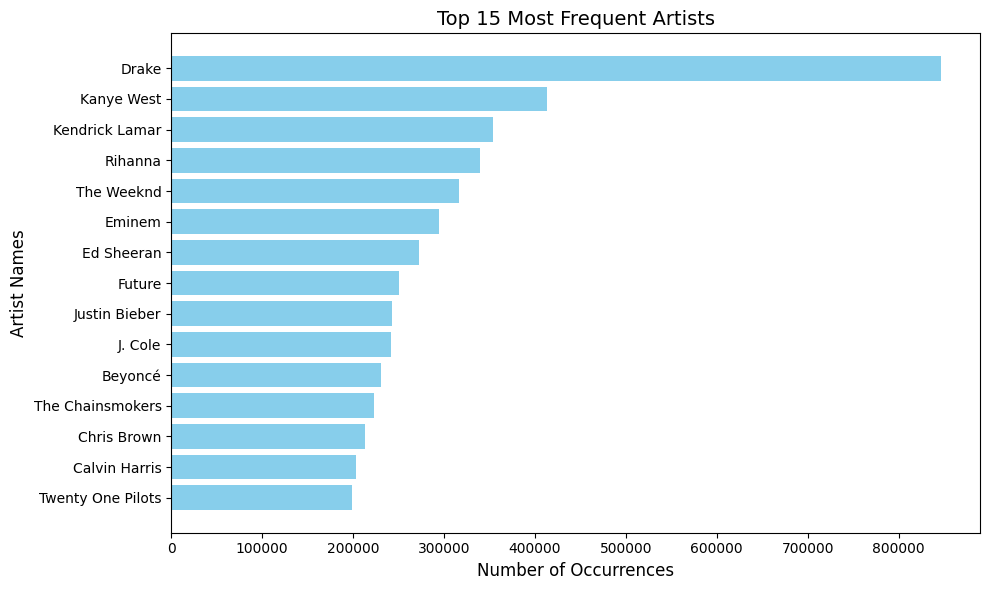

In [5]:
import dask.bag as db
import matplotlib.pyplot as plt

folder_path = 'data/'
num_files = 1000  
top_n_artists = 15  

file_pattern = [os.path.join(folder_path, f'mpd.slice.{i * 1000}-{(i + 1) * 1000 - 1}.json') for i in range(num_files)]

def extract_artist_names(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        artist_names = [track["artist_name"] for playlist in data["playlists"] for track in playlist["tracks"]]
    return artist_names

dask_bag = db.from_sequence(file_pattern).map(extract_artist_names)

artist_counts = dask_bag.flatten().frequencies().compute()

most_common_artists = sorted(artist_counts, key=lambda x: x[1], reverse=True)[:top_n_artists]
artists, counts = zip(*most_common_artists)

plt.figure(figsize=(10, 6))
plt.barh(artists[::-1], counts[::-1], color='skyblue')
plt.title(f"Top {top_n_artists} Most Frequent Artists", fontsize=14)
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("Artist Names", fontsize=12)
plt.tight_layout()
plt.show()


Top N first tracks in the first X playlist

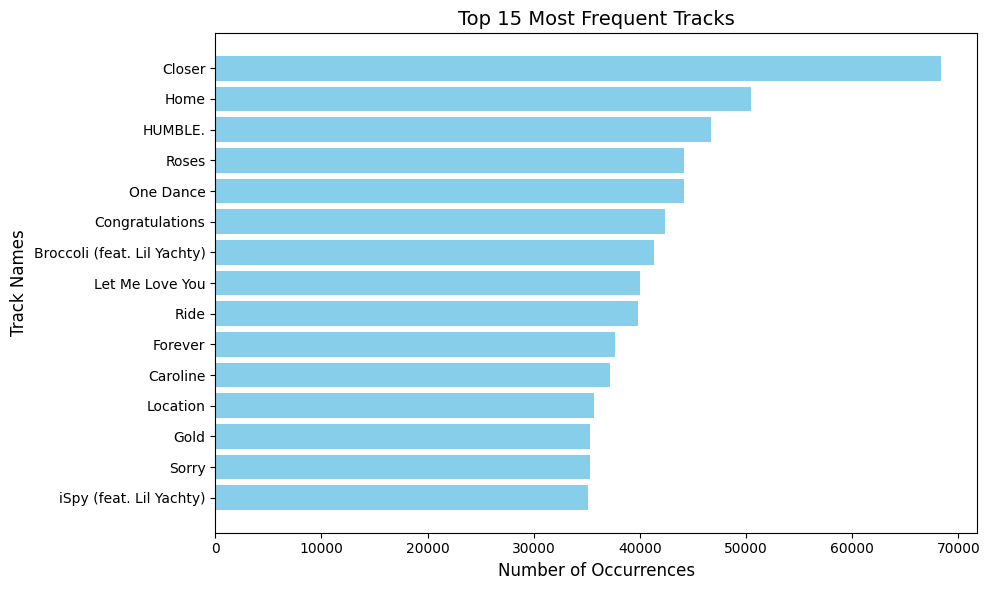

In [ ]:
import os
import json
import dask.bag as db
import matplotlib.pyplot as plt

folder_path = 'data/'
num_files = 1000  
top_n_tracks = 15 

file_pattern = [os.path.join(folder_path, f'mpd.slice.{i * 1000}-{(i + 1) * 1000 - 1}.json') for i in range(num_files)]

def extract_track_names(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        track_names = [track["track_name"] for playlist in data["playlists"] for track in playlist["tracks"]]
    return track_names

dask_bag = db.from_sequence(file_pattern).map(extract_track_names)

track_counts = dask_bag.flatten().frequencies().compute()

most_common_tracks = sorted(track_counts, key=lambda x: x[1], reverse=True)[:top_n_tracks]
artists, counts = zip(*most_common_tracks)

plt.figure(figsize=(10, 6))
plt.barh(artists[::-1], counts[::-1], color='skyblue')
plt.title(f"Top {top_n_tracks} Most Frequent Tracks", fontsize=14)
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("Track Names", fontsize=12)
plt.tight_layout()
plt.show()
